In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


**Start **

In [ ]:
import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# some initial setup
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [ ]:
DATA_DIR = '/gdrive/MyDrive/kaggle_plant/kaggle_plant/'
sz = 224
batch_size = 32

In [ ]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [ ]:
os.listdir(DATA_DIR)

['train', 'sample_submission.csv', 'test', 'valid']

In [ ]:
foldernames=os.listdir(f'{DATA_DIR}train')
print(foldernames)

['Sugar beet', 'Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Maize', 'Scentless Mayweed', 'Small-flowered Cranesbill', 'Loose Silky-bent', 'Shepherds Purse']


In [ ]:
os.listdir(f'{DATA_DIR}train')

['Sugar beet',
 'Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Maize',
 'Scentless Mayweed',
 'Small-flowered Cranesbill',
 'Loose Silky-bent',
 'Shepherds Purse']

In [ ]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [ ]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.png')
trn_fnames[:5]

['/gdrive/MyDrive/kaggle_plant/kaggle_plant/train/Sugar beet/fb57ce659.png',
 '/gdrive/MyDrive/kaggle_plant/kaggle_plant/train/Sugar beet/04c979351.png',
 '/gdrive/MyDrive/kaggle_plant/kaggle_plant/train/Sugar beet/0026b7a30.png',
 '/gdrive/MyDrive/kaggle_plant/kaggle_plant/train/Sugar beet/019e2ca3b.png',
 '/gdrive/MyDrive/kaggle_plant/kaggle_plant/train/Sugar beet/06a859dfd.png']

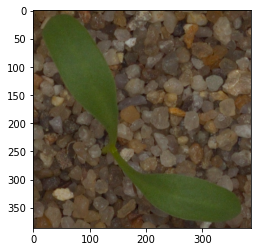

In [ ]:
img = plt.imread(trn_fnames[3])
plt.imshow(img);

In [ ]:
train_ds = datasets.ImageFolder(trn_dir)

In [ ]:
train_ds.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [ ]:
train_ds.class_to_idx

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [ ]:
train_ds.root

'/gdrive/MyDrive/kaggle_plant/kaggle_plant/train'

In [ ]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [ ]:
len(train_ds), len(valid_ds)

(4366, 384)

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=8)

valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False,num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


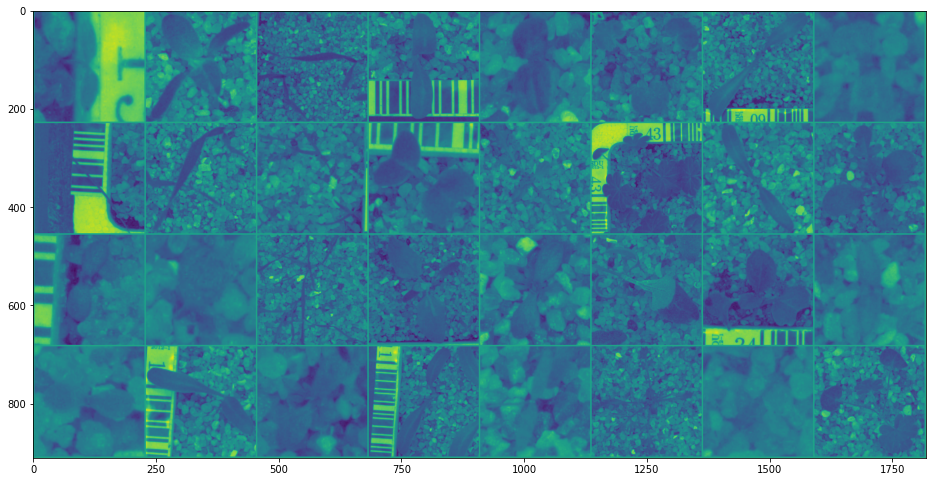

In [ ]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16., 12.))
plt.imshow(out[0,:,:])

In [ ]:
class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))



        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(56 * 56 * 32,50)
        self.fc1 = nn.Linear(50,12)
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H * W)
        out = self.fc(out)
        out = self.fc1(out)
        return out

In [ ]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [ ]:
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=50, bias=True)
  (fc1): Linear(in_features=50, out_features=12, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

In [ ]:
def train_model(model, train_dl,valid_dl,criterion, optimizer, device, num_epochs):
    losses = []

    for epoch in range(num_epochs):
        for i, (inputs, targets) in enumerate(train_dl):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forwad pass
            outputs = model(inputs)

            # loss
            loss = criterion(outputs, targets)
            losses.append(loss.item())

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update parameters
            optimizer.step()

            # report
            if (i + 1) % 10 == 0:
                print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                    % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))
    return inputs,targets,outputs

In [ ]:
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # forwad pass
        outputs = model(inputs)

        # loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update parameters
        optimizer.step()

        # report
        if (i + 1) % 10 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))

Epoch [ 1/10], Step [ 10/136], Loss: 8.6160
Epoch [ 1/10], Step [ 20/136], Loss: 3.3737
Epoch [ 1/10], Step [ 30/136], Loss: 2.3040
Epoch [ 1/10], Step [ 40/136], Loss: 2.0383
Epoch [ 1/10], Step [ 50/136], Loss: 2.4718
Epoch [ 1/10], Step [ 60/136], Loss: 2.1995
Epoch [ 1/10], Step [ 70/136], Loss: 1.7070
Epoch [ 1/10], Step [ 80/136], Loss: 1.6395
Epoch [ 1/10], Step [ 90/136], Loss: 1.7706
Epoch [ 1/10], Step [100/136], Loss: 1.5112
Epoch [ 1/10], Step [110/136], Loss: 1.5974
Epoch [ 1/10], Step [120/136], Loss: 1.9288
Epoch [ 1/10], Step [130/136], Loss: 1.5499
Epoch [ 2/10], Step [ 10/136], Loss: 1.9138
Epoch [ 2/10], Step [ 20/136], Loss: 1.4002
Epoch [ 2/10], Step [ 30/136], Loss: 1.4682
Epoch [ 2/10], Step [ 40/136], Loss: 1.6485
Epoch [ 2/10], Step [ 50/136], Loss: 1.2496
Epoch [ 2/10], Step [ 60/136], Loss: 1.5749
Epoch [ 2/10], Step [ 70/136], Loss: 1.1188
Epoch [ 2/10], Step [ 80/136], Loss: 1.2776
Epoch [ 2/10], Step [ 90/136], Loss: 1.1534
Epoch [ 2/10], Step [100/136], L

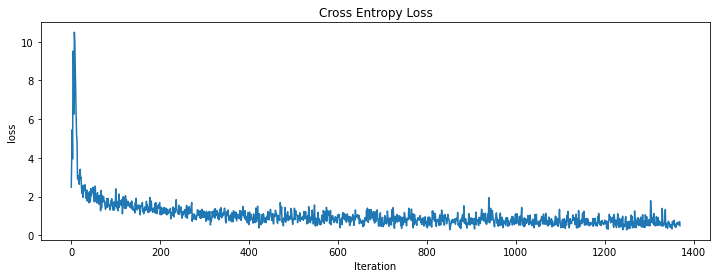

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

Accuracy on validation data

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()

    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [ ]:
evaluate_model(model, valid_dl, device)

accuracy: 74.22


In [ ]:
evaluate_model(model, train_dl, device)

accuracy: 79.45


confusion matrix

In [ ]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

 #Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}valid', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes


Train size: 4366
Valid size: 384 (0.08)


Text(0.5, 1.0, 'Augmented Images')

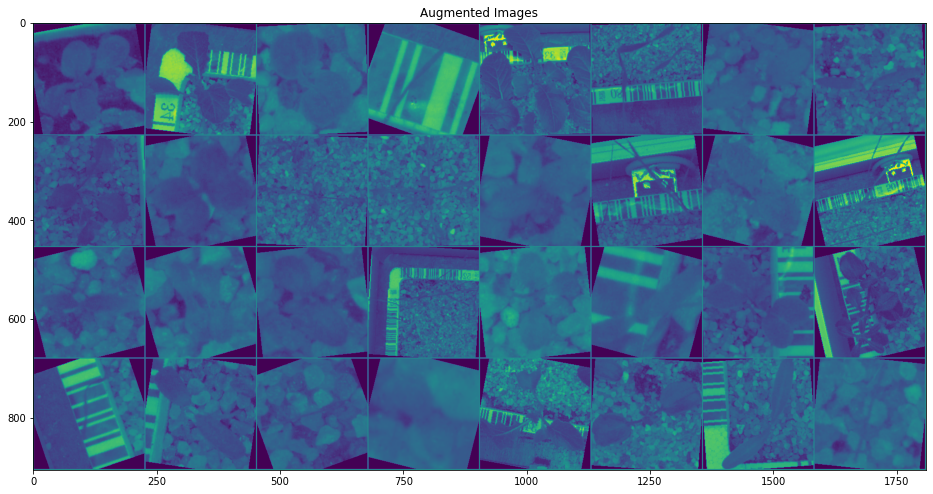

In [ ]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
plt.imshow(out[0,:,:])
plt.title('Augmented Images')

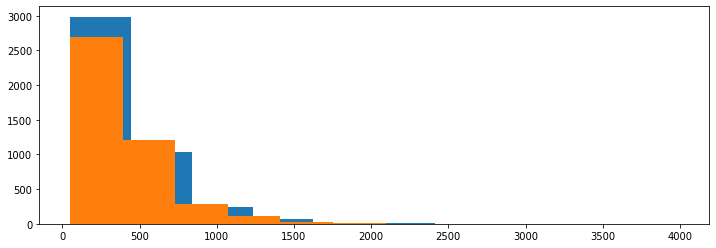

In [ ]:
fnames = glob.glob(f'{trn_dir}/*/*.png')
sizes = [Image.open(f).size for f in fnames]

hs,ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [ ]:
# create model
model = SimpleCNN()
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# train
inputs,targets,outputs = train_model(model, train_dl,valid_dl,criterion, optimizer, device, num_epochs=10)

Epoch [ 1/10], Step [ 10/136], Loss: 7.4000
Epoch [ 1/10], Step [ 20/136], Loss: 4.1996
Epoch [ 1/10], Step [ 30/136], Loss: 4.1235
Epoch [ 1/10], Step [ 40/136], Loss: 3.9064
Epoch [ 1/10], Step [ 50/136], Loss: 3.0347
Epoch [ 1/10], Step [ 60/136], Loss: 2.6160
Epoch [ 1/10], Step [ 70/136], Loss: 2.6424
Epoch [ 1/10], Step [ 80/136], Loss: 2.4709
Epoch [ 1/10], Step [ 90/136], Loss: 2.1423
Epoch [ 1/10], Step [100/136], Loss: 1.8715
Epoch [ 1/10], Step [110/136], Loss: 2.2282
Epoch [ 1/10], Step [120/136], Loss: 1.6085
Epoch [ 1/10], Step [130/136], Loss: 1.7759
Epoch [ 2/10], Step [ 10/136], Loss: 1.7103
Epoch [ 2/10], Step [ 20/136], Loss: 1.5797
Epoch [ 2/10], Step [ 30/136], Loss: 1.5639
Epoch [ 2/10], Step [ 40/136], Loss: 1.8932
Epoch [ 2/10], Step [ 50/136], Loss: 1.5259
Epoch [ 2/10], Step [ 60/136], Loss: 1.6318
Epoch [ 2/10], Step [ 70/136], Loss: 1.9913
Epoch [ 2/10], Step [ 80/136], Loss: 1.3862
Epoch [ 2/10], Step [ 90/136], Loss: 1.8220
Epoch [ 2/10], Step [100/136], L

In [ ]:
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=50, bias=True)
  (fc1): Linear(in_features=50, out_features=12, bias=True)
)

In [ ]:
evaluate_model(model, valid_dl, device)

accuracy: 69.27


In [ ]:
evaluate_model(model, train_dl, device)

accuracy: 80.07


In [ ]:
# load pre-trained vgg19
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
inputs,targets,outputs = train_model(model, train_dl, valid_dl, criterion, optimizer, device, num_epochs=10)

Epoch [ 1/10], Step [ 10/136], Loss: 3.5235
Epoch [ 1/10], Step [ 20/136], Loss: 3.2723
Epoch [ 1/10], Step [ 30/136], Loss: 2.8673
Epoch [ 1/10], Step [ 40/136], Loss: 2.4002
Epoch [ 1/10], Step [ 50/136], Loss: 2.5549
Epoch [ 1/10], Step [ 60/136], Loss: 2.1352
Epoch [ 1/10], Step [ 70/136], Loss: 2.1958
Epoch [ 1/10], Step [ 80/136], Loss: 2.1957
Epoch [ 1/10], Step [ 90/136], Loss: 2.0973
Epoch [ 1/10], Step [100/136], Loss: 2.0154
Epoch [ 1/10], Step [110/136], Loss: 2.0034
Epoch [ 1/10], Step [120/136], Loss: 1.8606
Epoch [ 1/10], Step [130/136], Loss: 1.5854
Epoch [ 2/10], Step [ 10/136], Loss: 1.5582
Epoch [ 2/10], Step [ 20/136], Loss: 1.8013
Epoch [ 2/10], Step [ 30/136], Loss: 1.2468
Epoch [ 2/10], Step [ 40/136], Loss: 1.1677
Epoch [ 2/10], Step [ 50/136], Loss: 1.6039
Epoch [ 2/10], Step [ 60/136], Loss: 1.4488
Epoch [ 2/10], Step [ 70/136], Loss: 1.0641
Epoch [ 2/10], Step [ 80/136], Loss: 1.3602
Epoch [ 2/10], Step [ 90/136], Loss: 1.3086
Epoch [ 2/10], Step [100/136], L

In [ ]:
evaluate_model(model, valid_dl, device)

accuracy: 90.62


In [ ]:
evaluate_model(model, train_dl, device)

accuracy: 96.79
